<a href="https://colab.research.google.com/github/MatienkoAndrew/notebooks/blob/main/SecondStepNLP_IntroDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение в Deep Learning. PyTorch Lightning

## Вступление
Сегодня вы узнаете, как обучать нейронные сети в библиотеке **PyTorch Lightning**, позволяющей сократить количество кода, которое нам приходится писать на **PyTorch**.

Что мы сделаем:

* узнаем как правильно загружать данные в pytorch
* сконструируем нашу первую нейронную сеть
* обучим ее 
* оценим качество готовой модели

In [1]:
!pip3 install pytorch_lightning torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(0xBADBEEF)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

## PyTorch Lightning

**PyTorch Lightning** это фреймворк для организованной работы с **PyTorch**. В нем упрощена работа по:
- Написанию тренировочного цикла
- Написанию датасетов
- Использованию gpu/tpu/ipu/hpu и тд
- Переводу моделей в формат ONNX
- И многому другому

Фреймворк призван оставить пользователю возможность конфигурировать параметры и проводить эксперименты, а остальное он возьмет на себя.

In [4]:
# from collections import defaultdict, namedtuple

# import pytorch_lightning as pl

# import torchvision
# import torchvision.transforms as transforms

# from torch.utils.data import DataLoader
# from torchmetrics.classification import MulticlassAccuracy

# mca = MulticlassAccuracy(num_classes=10, average=None) 

### Загрузка данных

Будем работать с датасетом `Fashion MNIST` - это стандартный датасет, он есть в библиотеке pytorch. Объекты в датасете - это изображения разных элементов одежды (всего 10 классов). Будем решать задачу классификации элементов одежды по фотографиям.

Так как датасет уже хранится в pytorch, то для его загрузки никаких вспомогательных действий не требуется - просто загружаем данные из библиотеки.

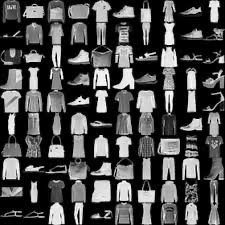

In [5]:
import torchvision
from torchvision import transforms

##-- Train data
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)


##-- Validation data
fashion_mnist_val = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

### DataLoader

В deep learning и обучение, и применение моделей происходит по `батчам` (батч - это группа объектов).

Например, на этапе обучения это будет значить, что градиент функции потерь будет считаться не по всем объектам выборки (очень долго!), а по одному батчу:

$$w_{k+1} = w_k - \eta\nabla L(w_k),$$
где
$$L(w_k)=\frac1b\sum\limits_{i=1}^b \nabla_i L(w_k),$$

а $b$ - число объектов в батче.



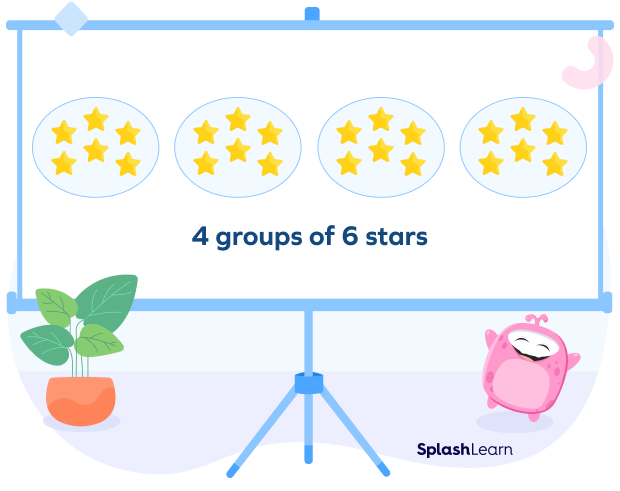

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как `DataLoader`, который принимает на вход класс унаследованный от torch.utils.data.Dataset. 

In [6]:
from torch.utils.data import DataLoader

BATCHSIZE = 128
NUMWORKERS = 8

train_dataloader = DataLoader(
    dataset=fashion_mnist_train,
    batch_size=BATCHSIZE,
    shuffle=True,
    num_workers=NUMWORKERS
)

val_dataloader = DataLoader(
    dataset=fashion_mnist_val,
    batch_size=BATCHSIZE,
    shuffle=False,
    num_workers=NUMWORKERS
)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Создадим словарь для перевода названия одежды в индекс.

In [7]:
from collections import defaultdict

idx_to_label = defaultdict(None, {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
})

Посмотрим на пару объектов из датасета.

Ankle Boot


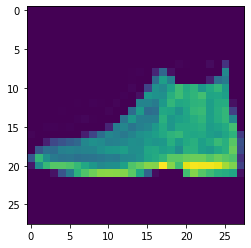

Coat


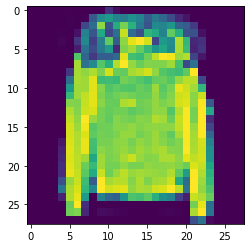

In [8]:
for batch in val_dataloader:
    images, class_nums = batch

    ##-- first picture
    print(idx_to_label[int(class_nums[0])])
    plt.imshow(images[0].squeeze())
    plt.show()

    ##-- last_picture
    print(idx_to_label[int(class_nums[-1])])
    plt.imshow(images[-1].squeeze())
    plt.show()
    break

## Модель

Создаем класс модели по следующей схеме:

1. Flatten
2. Linear(out=128)
3. ReLU
4. Linear(out=10)

### Loss

В задачах классификации мы обычно предсказываем не только классы, но и уверенность модели в ответе (вероятности). Для этого подходит `CrossEntropy loss` (или log-loss):

$$Loss = -\sum\limits_{i=1}^l y_i\cdot log(a(x_i)),$$
где $y_i$ - правильный ответ, а $a(x_i)$ - предсказание модели на $i$-м объекте.

In [9]:
# from collections import defaultdict, namedtuple

# import pytorch_lightning as pl

# import torchvision
# import torchvision.transforms as transforms

# from torch.utils.data import DataLoader
# from torchmetrics.classification import MulticlassAccuracy

# mca = MulticlassAccuracy(num_classes=10, average=None) 

In [46]:
##-- test
for batch in val_dataloader:
    images, targets = batch
    break
image = images[0]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [152]:
from torchmetrics.classification import MulticlassAccuracy
mca = MulticlassAccuracy(num_classes=10, average=None)

class EasyNet(torch.nn.Module): # задаем сеть, способ вычисления loss и метрику
    def __init__(self):
        super().__init__()
##-- conv2d
        # self.layer1 = nn.Sequential(
        #     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2)
        # )
        # self.layer2 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2)
        # )
        # self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # self.drop = nn.Dropout2d(0.25)
        # self.fc2 = nn.Linear(in_features=600, out_features=120)
        # self.fc3 = nn.Linear(in_features=120, out_features=10)
##--

## linear 3 hidden layers
    # self.layer1 = nn.Sequential(
    # nn.Flatten(), # вытягиваем матрицу (картинка - это матрица) в вектор (одномерный массив)
    # nn.Linear(28 * 28, 512), # полносвязный слой с 28*28 входными и 128 выходными нейронами
    # nn.ReLU(), # функция активации ReLU
    # nn.Linear(512, 256), # полносвязный слой с 28*28 входными и 128 выходными нейронами
    # nn.ReLU(), # функция активации ReLU
    # nn.Linear(256, 128), # полносвязный слой с 28*28 входными и 128 выходными нейронами
    # nn.ReLU(), # функция активации ReLU
    # nn.Linear(128, 10)
    # )
##--

##-- encoding architecture
###-- encoder
        self.encoded_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding='same'), ##Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.encoded_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.encoded_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1)
        )
###--

###-- decoder
        self.decoded_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2)
        )
        self.decoded_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2)
        )
        self.decoded_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2)
        )
###--

###-- linear
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64*28*28, out_features=1024)
        self.dropout = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=10)

        self.loss_func = nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()
###--
##--

    def _forward(self, x): # задаем последовательность слоев
##-- encoding architecture
        x = self.encoded_layer1(x)
        x = self.encoded_layer2(x)
        x = self.encoded_layer3(x)
        x = self.decoded_layer1(x)
        x = self.decoded_layer2(x)
        x = self.decoded_layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.out(x)
##--

##-- conv2d
        # x = self.layer1(x)
        # x = self.layer2(x)
        # print(x.shape)
        # x = x.view(x.size(0), -1)
        # print(x.shape)
        # x = self.fc1(x)
        # x = self.drop(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
##--

##-- linear 3 hidden layers
        # x = self.flatten(x)
        # x = self.linear1(x)
        # x = self.relu(x)
        # x = self.linear2(x)
#
        return x

    def forward(self, images, target=None):
        """
        images ~ (batch size, num channels, height, width)
        target ~ (batch size)
        output ~ (batch size, num classes)
        """
        output = self._forward(images) # предсказания модели

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target) # вычисляем ошибку модели
            self.targets = torch.cat((self.targets, target.cpu()), 0) # задаем значения целевой переменной
            pred = torch.argmax(output, dim=-1) # переводим предсказания модели в классы
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = mca(self.preds.long(), self.targets.long()) # вычисляем accuracy по всем текущим значениям
            return output, loss
        return output

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [153]:
from torchsummary import summary

net = EasyNet()
out = net.forward(images)
summary(net.cuda(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]          18,464
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 16, 7, 7]           4,624
              ReLU-8             [-1, 16, 7, 7]               0
         MaxPool2d-9             [-1, 16, 4, 4]               0
           Conv2d-10             [-1, 32, 4, 4]           4,640
             ReLU-11             [-1, 32, 4, 4]               0
UpsamplingNearest2d-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 64, 8, 8]          18,496
             ReLU-14             [-1,

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [154]:
net

EasyNet(
  (encoded_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoded_layer2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoded_layer3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (decoded_layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): UpsamplingNearest2d(scale_factor=2.0, mode=nearest)
  )
  (decoded_layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): UpsamplingNearest2d(scale_factor=2.0, mode=neares

### Тренировочные циклы (Lightning)

1) Создается 1 класс наследованный от `pl.LightningModule`. В нем описывается сама модель, необходимые функции тренировочного и валидационного шага.

2) Создается объект класса `pl.Trainer` с параметрами (номер гпу, кол-во эпох и так далее) подробнее можно посмотреть в документации [тут](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer) или [тут](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html?highlight=trainer#trainer-flags).

3) Вызывается `trainer.fit(model, train_loader, val_loader)`.


```
class MyModule(pl.LightningModule):
    def init():
        init_model()
    def forward():
        forward_model()
    def training_step():
        make_1_training_step()
    def validation_step():
        make_1_validation_step()

trainer = pl.Trainer(gpus=1, max_epochs=10)
trainer.fit(model, train_loader, val_loader)
```
Поскольку у нас уже есть модель `EasyNet`, то осталось сделать немного.

In [155]:
import pytorch_lightning as pl

# 1) create a LightningModule
class SimpleModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), # вариант градиентного спуска, который мы используем
                                     lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx): # шаг обучения: вычисляем лосс на батче
        images, targets = train_batch
        _, loss = self.model(images, targets)
        self.log("train_loss", loss, prog_bar=True) # сохраняет логи в папку
        return loss

    def validataion_step(self, val_batch, batch_idx): # шаг валидации - аналогичный
        images, targets = val_batch
        _, loss = self.model(images, targets)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self, test_batch, batch_idx): # шаг тестирования - вычисляем ту метрику или функцию потерь, которую хотим
        images, targets = test_batch

        preds = self.model(images)
        pred_classes = torch.argmax(preds, dim=-1) # переводим предсказания модели в классы
        accuracy = mca(pred_classes.cpu(), targets.cpu()).mean()
        self.log('test_accuracy', accuracy, prog_bar=True)

In [163]:
from collections import namedtuple

##-- гиперпараметры
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'

LossInfo = namedtuple(
    "LossInfo",
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)

EPOCHS = 20
LR = 0.001

model = EasyNet().to(device) # объявляем сеть, переносим ее на gpu 

# 2) create module
module = SimpleModule( # объявляем модуль для обучения сети
    model,
    learning_rate=LR
)


# 3) create Trainer and train (±30 seconds on gpu)
trainer = pl.Trainer( # выбираем параметры обучения
    accelerator=accelerator,
    max_epochs=EPOCHS
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Train




In [164]:
trainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | EasyNet | 52.2 M
----------------------------------
52.2 M    Trainable params
0         Non-trainable params
52.2 M    Total params
208.621   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


При использовании `trainer.fit()` все шаги обучения:
* итерирование по эпохам и по батчам
* вычисление градиентов, обновление весов модели
* перенос модели и данных на GPU и другое
делается под капотом.

Это удобно, мы можем не волноваться, что забудем сделать какой-то важный шаг в обучении. Кроме того, код становится прозрачным и хорошо читаемым.

Для сравнения вы можете посмотреть на объем кода в обучающем цикле без использования lightning, например, [здесь](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy).

## Тестирование и анализ качества модели

Посмотрим на `accuracy` модели по всем валидационным данным.

Для тестирования модели через `trainer.test` нужно добавить в наш класс `SimpleModule` метод `test_step` - и написать в нем, что и как мы вычисляем. В этой задаче вычисляем `accuracy`. 

In [165]:
##-- encoding architechture
trainer.test(module, dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9109950065612793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9109950065612793}]

In [24]:
## linear 3 hidden layers
trainer.test(module, dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8695290088653564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.8695290088653564}]

In [15]:
## linear 1 hidden layers (10 epochs)
trainer.test(module, dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8706423044204712
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.8706423044204712}]

Визуально оценим качество модели. Выведем на экран объекты, на которых модель ошибается.

Correct answer: Sneaker
Predicted answer: Sandal


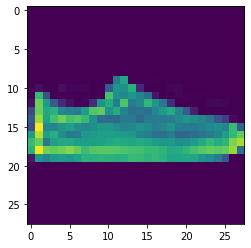

Correct answer: Ankle Boot
Predicted answer: Sandal


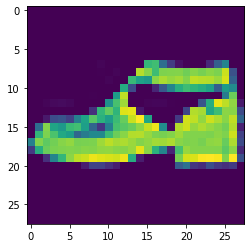

Correct answer: Shirt
Predicted answer: T-shirt/Top


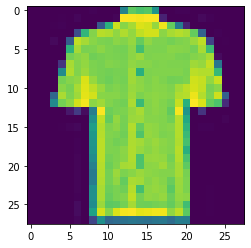

Correct answer: Dress
Predicted answer: Shirt


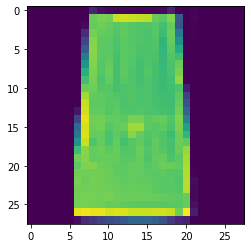

Correct answer: Sneaker
Predicted answer: Ankle Boot


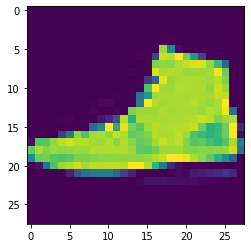

Correct answer: Pullover
Predicted answer: Shirt


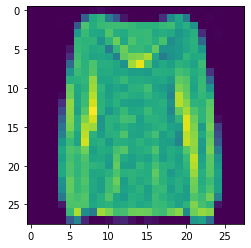

Correct answer: Pullover
Predicted answer: Coat


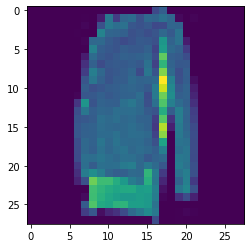

Correct answer: Ankle Boot
Predicted answer: Sneaker


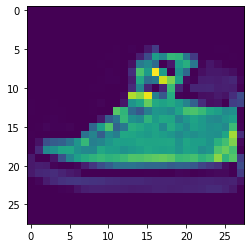

Correct answer: Ankle Boot
Predicted answer: Sneaker


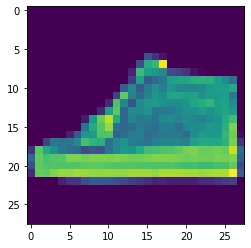

Correct answer: Shirt
Predicted answer: Coat


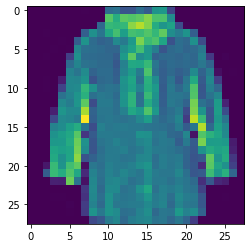

10 errors of 128


In [166]:
errors = 0
module.eval()

with torch.no_grad():
    for batch in val_dataloader:
        images, class_nums = batch
        preds = module(images)
        pred_classes = torch.argmax(preds, dim=-1) # переводим предсказания модели в классы

        for i in range(BATCHSIZE): # нарисуем только объекты с неверными предсказаниями
            correct_answer = idx_to_label[int(class_nums[i])]
            predicted_answer = idx_to_label[int(pred_classes[i])]

            if correct_answer != predicted_answer:
                errors += 1
                print(f"Correct answer: {correct_answer}")
                print(f"Predicted answer: {predicted_answer}")
                plt.imshow(images[i].squeeze())
                plt.show()
        break

print(f"{errors} errors of 128")